In [ ]:
import os
import faiss
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from models.Dino import ImageEmbeddingModel

In [9]:

MODEL_PATH = "./models/triplet_dino.pth"
PCA_MODEL_PATH = "./npy/pca_model.joblib"
REDUCED_EMBEDDING = "./npy/image_embeddings_pca256.npy"
IMAGE_LIST = "./faiss/image_filenames.npy"
IMAGE_DIR = "./images"

EMBEDDING_DIM = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pca = joblib.load(PCA_MODEL_PATH)
reduced_embeddings = np.load(REDUCED_EMBEDDING).astype("float32")
image_filenames = np.load(IMAGE_LIST, allow_pickle=True)

model = ImageEmbeddingModel(output_dim=768).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def get_class_from_filename(filename):
    return filename.split("_")[0]

def get_thumbnail(path, size=(256, 256)):
    thumb_dir = "./images/thumbnails"
    os.makedirs(thumb_dir, exist_ok=True)
    name = os.path.basename(path)
    thumb_path = os.path.join(thumb_dir, name)
    if not os.path.exists(thumb_path):
        img = Image.open(path).convert("RGB")
        img.resize(size).save(thumb_path)
    return Image.open(thumb_path)

def search_similar_images(query_image_path, top_k=5):
    # Load and encode query
    img = Image.open(query_image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        query_embedding = model(img_tensor).cpu().numpy()
    query_pca = pca.transform(query_embedding)

    # Get query class from filename
    query_filename = os.path.basename(query_image_path)
    query_class = get_class_from_filename(query_filename)

    # Filter by class
    mask = np.array([get_class_from_filename(f) == query_class for f in image_filenames])
    filtered_embeddings = reduced_embeddings[mask]
    filtered_filenames = image_filenames[mask]

    if len(filtered_filenames) == 0:
        print(f"No images found for class: {query_class}")
        return img, []

    # Build temporary index
    temp_index = faiss.IndexFlatL2(EMBEDDING_DIM)
    temp_index.add(filtered_embeddings)

    # Search more than needed, to allow for exclusion
    D, I = temp_index.search(query_pca, top_k + 5)

    # Filter out the query image itself
    result_paths = []
    for idx in I[0]:
        candidate = os.path.basename(filtered_filenames[idx])
        if candidate != query_filename:
            result_paths.append(os.path.join(IMAGE_DIR, filtered_filenames[idx]))
        if len(result_paths) == top_k:
            break

    return img, result_paths

def show_and_save_results(query_img, result_paths, save_path=None):
    fig, axes = plt.subplots(1, len(result_paths) + 1, figsize=(4 * (len(result_paths)+1), 4))

    # Show query
    axes[0].imshow(query_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, path in enumerate(result_paths):
        img = get_thumbnail(path)
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Top {i+1}")
        axes[i+1].axis("off")

    plt.tight_layout()
    if save_path is None:
        query_name = os.path.splitext(os.path.basename(result_paths[0]))[0]
        save_path = f"./output/query_result_{query_name}.jpg"
    plt.savefig(save_path)
    plt.show()
    print(f"Saved result image to {save_path}")



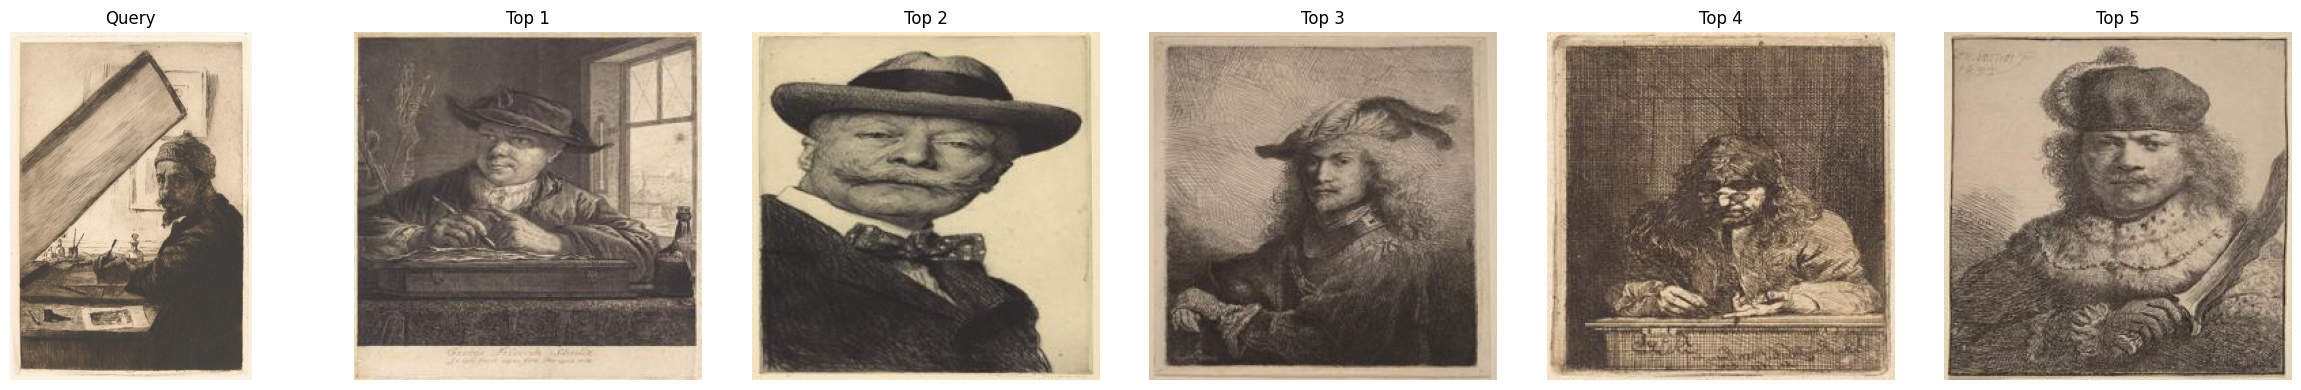

Saved result image to ./output/query_result_print_73409.jpg


In [12]:
query = "./images/print_222928.jpg"
query_img, result_paths = search_similar_images(query, top_k=5)

if result_paths:
    show_and_save_results(query_img, result_paths)
